In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from pymc import sampling_jax
import altair as alt
import igraph
alt.renderers.enable('mimetype')
pm.__version__

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


'5.0.2'

## Getting data

In [10]:
monks = pd.read_csv("../../../datasets/Monks.csv", sep=";")
monks.describe().round(1)

,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA
count,153.0,153.0,153.0,153.0,153.0,153.0,153.0
mean,77.0,6.3,12.7,0.3,0.5,0.3,0.3
std,44.3,4.1,4.1,0.7,1.0,0.8,0.8
min,1.0,1.0,2.0,0.0,0.0,0.0,0.0
25%,39.0,3.0,10.0,0.0,0.0,0.0,0.0
50%,77.0,6.0,13.0,0.0,0.0,0.0,0.0
75%,115.0,9.0,16.0,0.0,0.0,0.0,0.0
max,153.0,17.0,18.0,3.0,3.0,3.0,3.0


Let's set up monk coordinates with names

In [94]:
monk_id_name_pairs = set(
    zip(monks['B'] - 1, monks['B_name'])
).union(
    set(zip(monks['A'] - 1, monks['A_name'])
))
monk_ids, monk_names = zip(*monk_id_name_pairs)

# Ex 1 

The data in data(Monks) are “like” and “dislike” nominations by 18 monks living
in the same monastery over three time periods. Therefore the observed variables are
counts from 0 to 3 of times monk A nominated monk B as liked or disliked. Each
row in the data is a pair of monks (a dyad). The variables are:

 - A: Index number for first monk in dyad
 - B: Index number for second monk in dyad
 - like_AB: Number of times A nominated B as liked
 - like_BA: Number of times B nominated A as liked
 - dislike_AB: Number of times A nominated B as disliked
 - dislike_BA: Number of times B nominated A as disliked

Use these data to estimate the amount of reciprocity in “like” nominations within
dyads. You can ignore the “dislike” data for now. Use the social network example
from the book to help, but you should modify it appropriately.

In [148]:
coords = {
    'monks': monk_names,
    'dyads': monks.dyad_id.values,
    'pair': ['nominated by', 'nominee'],
}


def likes(data, RVs):
    data['liked_by_A'] = pm.MutableData("liked_by_A", monks['like_AB'], dims='dyads')
    data['liked_by_B'] = pm.MutableData("liked_by_B", monks['like_BA'], dims='dyads')
    data['attempts'] = pm.MutableData("attempts", [3] * len(monks), dims='dyads')

    #parameters
    RVs['α'] = pm.Normal('α, general rate of liking', -2, 1) #the general possibility of liking should be quite low

    #estimation of social ties
    σ = pm.Exponential.dist(1.0)    
    Z = pm.Normal('Z', mu=0, sigma=1, dims=["pair", "dyads"])
    chol, corr, stds = pm.LKJCholeskyCov('monk_ties', n=len(coords['pair']), eta=2, sd_dist=σ, compute_corr=True)
    vals = pm.math.dot(chol, Z)
    RVs['AB_like'] = pm.Deterministic("AB_like", vals[0, :], dims="dyads")
    RVs['BA_like'] = pm.Deterministic("BA_like", vals[1, :], dims="dyads")
    pm.Deterministic("Monk like reciprocity", corr[1,0])
    RVs['like_corr'] = corr[1,0]


with pm.Model(coords=coords) as ex1_model:
    data = {}
    RVs = {}
    likes(data, RVs)

    #two binomial models
    #A -> B model
    logit_p_AB = RVs['α'] + RVs['AB_like'] 
    pm.Binomial("likes AB", n = data['attempts'], logit_p = logit_p_AB, dims='dyads', observed = data['liked_by_A'])

    #B -> A model
    logit_p_BA = RVs['α'] + RVs['BA_like'] 
    pm.Binomial("likes BA", n = data['attempts'], logit_p = logit_p_BA, dims='dyads', observed = data['liked_by_B'])

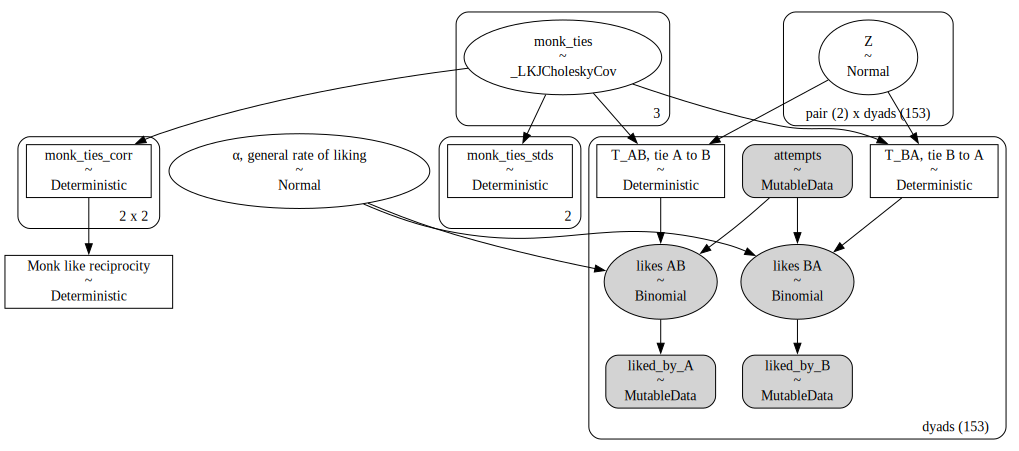

In [99]:
pm.model_to_graphviz(ex1_model)

In [100]:
with ex1_model:
    ex1_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:02.524101
Sampling...
Sampling time =  0:00:06.363817
Transforming variables...
Transformation time =  0:00:01.299514


In [101]:
az.summary(
    ex1_trace, 
    var_names=['α, general rate of liking', 'Monk like reciprocity'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-4.401,0.450,-5.252,-3.572,0.009,0.006,2507.0,2141.0,1.0
Monk like reciprocity,0.659,0.105,0.461,0.841,0.003,0.002,1093.0,1820.0,1.0


## Adding dislike nominations

In [150]:
def dislikes_using_likes(data, RVs):
    data['disliked_by_A'] = pm.MutableData("disliked_by_A", monks['dislike_AB'], dims='dyads')
    data['disliked_by_B'] = pm.MutableData("disliked_by_B", monks['dislike_BA'], dims='dyads')

    #parameters
    RVs['β'] = pm.Normal('β, general rate of disliking', -2, 1) #the general possibility of disliking should be quite low
    RVs['γ'] = pm.Normal('γ, impact of social tie on disliking', 0, 1) #this will allow using the same social tie variable, but moderate/reverse its effect

    

In [151]:
with pm.Model(coords=coords) as ex2_model:
    
    data = {}
    RVs = {}
    likes(data, RVs)
    dislikes_using_likes(data, RVs)

    #two binomial models for liking (same as before)
    #A -> B model
    logit_p_AB = RVs['α'] + RVs['AB_like'] 
    pm.Binomial("likes AB", n = data['attempts'], logit_p = logit_p_AB, dims='dyads', observed = data['liked_by_A'])

    #B -> A model
    logit_p_BA = RVs['α'] + RVs['BA_like'] 
    pm.Binomial("likes BA", n = data['attempts'], logit_p = logit_p_BA, dims='dyads', observed = data['liked_by_B'])

    #two more binomial models for disliking
    #A -> B model
    logit_dislike_AB = RVs['β'] + RVs['γ'] * RVs['AB_like'] 
    pm.Binomial("dislikes AB", n = data['attempts'], logit_p = logit_dislike_AB, dims='dyads', observed = data['disliked_by_A'])

    #B -> A model
    logit_dislike_BA = RVs['β'] + RVs['γ'] * RVs['BA_like'] 
    pm.Binomial("dislikes BA", n = data['attempts'], logit_p = logit_dislike_BA, dims='dyads', observed = data['disliked_by_B'])


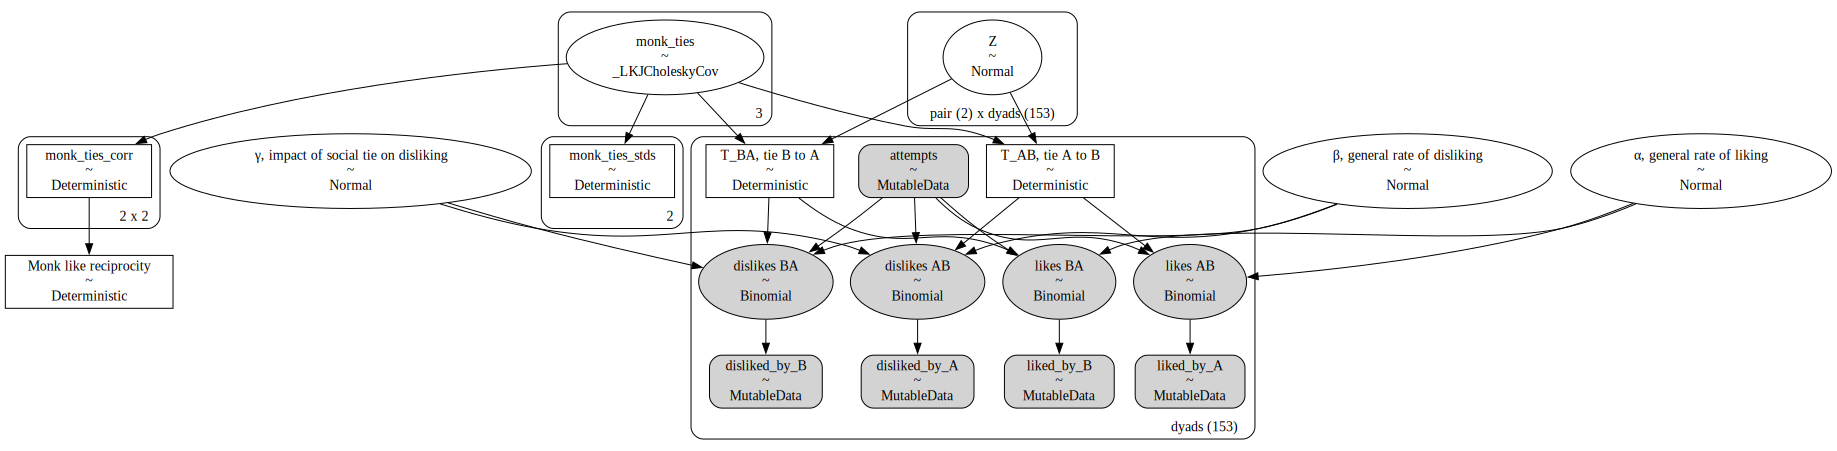

In [104]:
pm.model_to_graphviz(ex2_model)

In [105]:
with ex2_model:
    ex2_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:04.659740
Sampling...
Sampling time =  0:00:09.417155
Transforming variables...
Transformation time =  0:00:03.373261


In [107]:
az.summary(
    ex2_trace, 
    var_names=['α, general rate of liking', 'Monk like reciprocity', 'β, general rate of disliking', 'γ, impact of social tie on disliking'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-3.199,0.307,-3.804,-2.683,0.012,0.009,811.0,719.0,1.00
Monk like reciprocity,0.453,0.105,0.250,0.638,0.004,0.003,826.0,1619.0,1.01
"β, general rate of disliking",-4.051,0.503,-5.045,-3.131,0.018,0.013,749.0,713.0,1.00
"γ, impact of social tie on disliking",-1.482,0.401,-2.270,-0.726,0.017,0.012,520.0,447.0,1.01


## Dislikes v2 - adding "dislike ties" instead

In [156]:
def dislikes(data, RVs):
    data['disliked_by_A'] = pm.MutableData("disliked_by_A", monks['dislike_AB'], dims='dyads')
    data['disliked_by_B'] = pm.MutableData("disliked_by_B", monks['dislike_BA'], dims='dyads')

    #parameters
    RVs['β'] = pm.Normal('β, general rate of disliking', -2, 1) #the general possibility of disliking should be quite low
    
    #estimation of "dislike" ties
    σ = pm.Exponential.dist(1.0)    
    Z = pm.Normal('Z_dislike', mu=0, sigma=1, dims=["pair", "dyads"])
    chol, corr, stds = pm.LKJCholeskyCov('monk_dislike_ties', n=len(coords['pair']), eta=2, sd_dist=σ, compute_corr=True)
    vals = pm.math.dot(chol, Z)
    RVs['AB_dislike'] = pm.Deterministic("Dislike_AB, disliking from A to B", vals[0, :], dims="dyads")
    RVs['BA_dislike'] = pm.Deterministic("Dislike_BA, disliking from B to A", vals[1, :], dims="dyads")
    pm.Deterministic("Monk dislike reciprocity", corr[1,0])
    RVs['dislike_corr'] = corr[1,0]

    pm.Deterministic("reciprocity contrast", RVs['like_corr'] - RVs['dislike_corr'])

def like_dislike_likelihood(data, RVs):

    #two binomial models for liking (same as before)
    #A -> B model
    logit_p_AB = RVs['α'] + RVs['AB_like'] 
    pm.Binomial("likes AB", n = data['attempts'], logit_p = logit_p_AB, dims='dyads', observed = data['liked_by_A'])

    #B -> A model
    logit_p_BA = RVs['α'] + RVs['BA_like'] 
    pm.Binomial("likes BA", n = data['attempts'], logit_p = logit_p_BA, dims='dyads', observed = data['liked_by_B'])

    #two more binomial models for disliking
    #A -> B model
    logit_dislike_AB = RVs['β'] + RVs['AB_dislike']
    pm.Binomial("dislikes AB", n = data['attempts'], logit_p = logit_dislike_AB, dims='dyads', observed = data['disliked_by_A'])

    #B -> A model
    logit_dislike_BA = RVs['β'] + RVs['BA_dislike'] 
    pm.Binomial("dislikes BA", n = data['attempts'], logit_p = logit_dislike_BA, dims='dyads', observed = data['disliked_by_B'])
    

In [157]:
with pm.Model(coords=coords) as ex2_dislike_ties_model:
    data = {}
    RVs = {}
    likes(data, RVs)
    dislikes(data, RVs)
    like_dislike_likelihood(data, RVs)

In [158]:
with ex2_dislike_ties_model:
    ex2_dislike_ties_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:05.295476
Sampling...
Sampling time =  0:00:10.284506
Transforming variables...
Transformation time =  0:00:03.306012


In [159]:
az.summary(
    ex2_dislike_ties_trace, 
    var_names=['α, general rate of liking', 'Monk like reciprocity', 'β, general rate of disliking', 'Monk dislike reciprocity', 'reciprocity contrast'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-4.405,0.459,-5.259,-3.549,0.009,0.006,2546.0,2543.0,1.0
Monk like reciprocity,0.659,0.108,0.460,0.854,0.003,0.002,1151.0,2092.0,1.0
"β, general rate of disliking",-4.775,0.470,-5.646,-3.921,0.009,0.006,2984.0,3052.0,1.0
Monk dislike reciprocity,0.440,0.135,0.192,0.695,0.004,0.003,1315.0,2457.0,1.0
reciprocity contrast,0.219,0.172,-0.096,0.548,0.005,0.003,1265.0,2193.0,1.0


## One more approach: like & dislike ties should be correlated, too!

In [160]:
coords['double-pair'] = ['AB_like', 'BA_like', 'AB_dislike', 'BA_dislike']

def joint_likes_dislikes(data, RVs):
    data['liked_by_A'] = pm.MutableData("liked_by_A", monks['like_AB'], dims='dyads')
    data['liked_by_B'] = pm.MutableData("liked_by_B", monks['like_BA'], dims='dyads')
    data['attempts'] = pm.MutableData("attempts", [3] * len(monks), dims='dyads')
    data['disliked_by_A'] = pm.MutableData("disliked_by_A", monks['dislike_AB'], dims='dyads')
    data['disliked_by_B'] = pm.MutableData("disliked_by_B", monks['dislike_BA'], dims='dyads')

    #parameters
    RVs['α'] = pm.Normal('α, general rate of liking', -2, 1) #the general possibility of liking should be quite low
    RVs['β'] = pm.Normal('β, general rate of disliking', -2, 1) #the general possibility of disliking should be quite low

    #estimation of social ties (4-x)
    σ = pm.Exponential.dist(1.0)    
    Z = pm.Normal('Z', mu=0, sigma=1, dims=["double-pair", "dyads"])
    chol, corr, stds = pm.LKJCholeskyCov('monk_ties', n=len(coords['double-pair']), eta=2, sd_dist=σ, compute_corr=True)
    vals = pm.math.dot(chol, Z)

    RVs['AB_like'] = pm.Deterministic("AB_like", vals[0, :], dims="dyads")
    RVs['BA_like'] = pm.Deterministic("BA_like", vals[1, :], dims="dyads")
    RVs['AB_dislike'] = pm.Deterministic("AB_dislike", vals[2, :], dims="dyads")
    RVs['BA_dislike'] = pm.Deterministic("BA_dislike", vals[3, :], dims="dyads")

    #difference in strength of ties
    pm.Deterministic("Monk like reciprocity", corr[0,1])
    pm.Deterministic("Monk dislike reciprocity", corr[2,3])
    pm.Deterministic("reciprocity contrast", corr[0,1] - corr[2,3])


with pm.Model(coords=coords) as ex2_joint_ties_model:
    data = {}
    RVs = {}
    joint_likes_dislikes(data, RVs)
    like_dislike_likelihood(data, RVs)


In [161]:
with ex2_joint_ties_model:
    ex2_joint_ties_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:04.329701
Sampling...
Sampling time =  0:00:07.678745
Transforming variables...
Transformation time =  0:00:03.947685


In [163]:
az.summary(
    ex2_joint_ties_trace, 
    var_names=['α, general rate of liking', 'Monk like reciprocity', 'β, general rate of disliking', 'Monk dislike reciprocity', 'reciprocity contrast'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-4.434,0.464,-5.288,-3.571,0.009,0.006,2760.0,2879.0,1.0
Monk like reciprocity,0.641,0.106,0.442,0.831,0.003,0.002,1696.0,2532.0,1.0
"β, general rate of disliking",-4.792,0.481,-5.723,-3.949,0.008,0.006,3598.0,2881.0,1.0
Monk dislike reciprocity,0.423,0.133,0.186,0.671,0.003,0.002,2052.0,2819.0,1.0
reciprocity contrast,0.218,0.170,-0.117,0.527,0.004,0.003,1856.0,2791.0,1.0


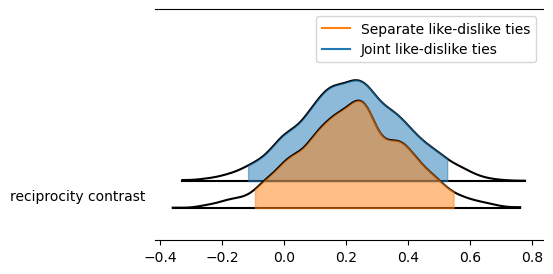

In [164]:
az.plot_forest(
    [ex2_joint_ties_trace,ex2_dislike_ties_trace], 
    var_names=['reciprocity contrast'], 
    combined=True,
    kind='ridgeplot',    
    ridgeplot_alpha=0.5,
    ridgeplot_truncate=False,
    ridgeplot_overlap=3,
    model_names=['Joint like-dislike ties', 'Separate like-dislike ties'],
    figsize=(5,3)
)
plt.show()

## Generalized liking/disliking

In [222]:
coords['monk_features'] = ['likeliness', 'dislikeness']


def generalized_liking(data, RVs):
    #add monk indicators
    data['monk_A'] = pm.MutableData('monk_A', monks['A'] - 1, coords='monks', dims='dyads')
    data['monk_B'] = pm.MutableData('monk_B', monks['B'] - 1, coords='monks', dims='dyads')

    #estimation of general likeliness / dislikeness of each monk 
    Z_monk = pm.Normal('Z_monk', mu=0, sigma=1, dims=["monk_features", "monks"])
    chol_monk, corr_monk, stds_monk = pm.LKJCholeskyCov(
        'monk_attributes', 
        n=len(coords['monk_features']), 
        eta=2, 
        sd_dist=pm.Exponential.dist(1.0), 
        compute_corr=True
    )
    vals_monk = pm.math.dot(chol_monk, Z_monk)
    RVs['Likeness'] = pm.Deterministic("Likeness", vals_monk[0, :], dims="monks")
    RVs['Dislikeness'] = pm.Deterministic("Dislikeness", vals_monk[1, :], dims="monks")
    pm.Deterministic("Monk like-dislike correlation", corr_monk[1,0])

def likelihood_generalized(data, RVs):
    #two binomial models for liking (same as before)
    #A -> B model
    logit_p_AB = RVs['α'] + RVs['AB_like'] + RVs['Likeness'][data['monk_B']]
    pm.Binomial("likes AB", n = data['attempts'], logit_p = logit_p_AB, dims='dyads', observed = data['liked_by_A'])

    #B -> A model
    logit_p_BA = RVs['α'] + RVs['BA_like'] + RVs['Likeness'][data['monk_A']]
    pm.Binomial("likes BA", n = data['attempts'], logit_p = logit_p_BA, dims='dyads', observed = data['liked_by_B'])

    #two more binomial models for disliking
    #A -> B model
    logit_dislike_AB = RVs['β'] + RVs['AB_dislike'] + RVs['Dislikeness'][data['monk_B']]
    pm.Binomial("dislikes AB", n = data['attempts'], logit_p = logit_dislike_AB, dims='dyads', observed = data['disliked_by_A'])

    #B -> A model
    logit_dislike_BA = RVs['β'] + RVs['BA_dislike'] + RVs['Dislikeness'][data['monk_A']]
    pm.Binomial("dislikes BA", n = data['attempts'], logit_p = logit_dislike_BA, dims='dyads', observed = data['disliked_by_B'])

In [176]:
with pm.Model(coords=coords) as ex3_generalized_model:
    
    data = {}
    RVs = {}
    likes(data, RVs)
    dislikes(data, RVs)
    generalized_liking(data, RVs)
    likelihood_generalized(data, RVs)

In [177]:
with ex3_generalized_model:
    ex3_generalized_trace = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:06.609547
Sampling...
Sampling time =  0:00:13.515338
Transforming variables...
Transformation time =  0:00:21.018012


In [178]:
az.summary(
    ex3_generalized_trace, 
    var_names=['α, general rate of liking', 'Monk like reciprocity', 'β, general rate of disliking', 'Monk dislike reciprocity', 'reciprocity contrast'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-4.424,0.458,-5.292,-3.587,0.010,0.007,1972.0,2581.0,1.00
Monk like reciprocity,0.663,0.107,0.461,0.848,0.004,0.003,892.0,1413.0,1.00
"β, general rate of disliking",-4.381,0.599,-5.558,-3.287,0.014,0.010,1767.0,2220.0,1.00
Monk dislike reciprocity,0.532,0.157,0.234,0.805,0.005,0.004,866.0,1659.0,1.01
reciprocity contrast,0.131,0.194,-0.222,0.501,0.007,0.005,811.0,1544.0,1.01


## Generalized effects with joint dislike-like modelling

In [223]:
with pm.Model(coords=coords) as ex3_generalized_model_joint:
    data = {}
    RVs = {}
    joint_likes_dislikes(data, RVs)
    generalized_liking(data, RVs)
    likelihood_generalized(data, RVs)


In [224]:
with ex3_generalized_model_joint:
    ex3_generalized_trace_joint = sampling_jax.sample_blackjax_nuts()

Compiling...
Compilation time =  0:00:05.933041
Sampling...
Sampling time =  0:00:12.372282
Transforming variables...
Transformation time =  0:00:04.804412


In [225]:
az.summary(
    ex3_generalized_trace_joint, 
    var_names=['α, general rate of liking', 'Monk like reciprocity', 'β, general rate of disliking', 'Monk dislike reciprocity', 'reciprocity contrast', 'Monk like-dislike correlation'], 
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"α, general rate of liking",-4.406,0.471,-5.302,-3.552,0.012,0.008,1557.0,2004.0,1.00
Monk like reciprocity,0.644,0.107,0.438,0.826,0.004,0.003,709.0,1455.0,1.01
"β, general rate of disliking",-4.392,0.604,-5.607,-3.316,0.015,0.011,1661.0,2340.0,1.00
Monk dislike reciprocity,0.490,0.153,0.181,0.755,0.004,0.003,1410.0,2378.0,1.00
reciprocity contrast,0.154,0.189,-0.200,0.506,0.006,0.004,1057.0,1454.0,1.00
Monk like-dislike correlation,-0.087,0.413,-0.825,0.648,0.024,0.017,311.0,665.0,1.01


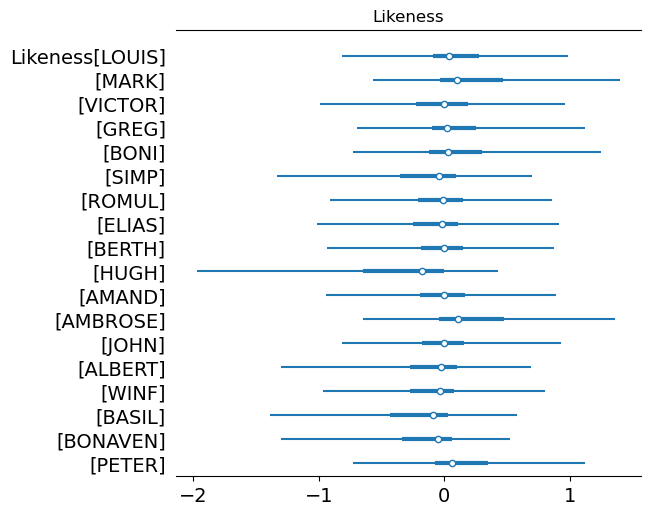

In [226]:
ax = az.plot_forest(ex3_generalized_trace_joint, var_names=['Likeness'], combined=True)
ax[0].set_title("Likeness")
plt.show()

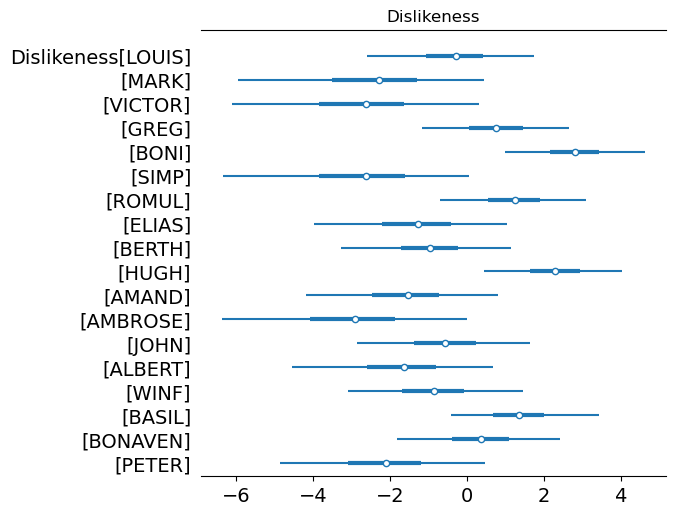

In [227]:
ax = az.plot_forest(ex3_generalized_trace_joint, var_names=['Dislikeness'], combined=True)
ax[0].set_title("Dislikeness")
plt.show()

In [228]:
mean_likeness = pd.DataFrame(ex3_generalized_trace_joint['posterior']['Likeness'].mean(dim=['chain', 'draw']).to_pandas()).rename({0: "Likeness"}, axis=1)
mean_dislikeness = pd.DataFrame(ex3_generalized_trace_joint['posterior']['Dislikeness'].mean(dim=['chain', 'draw']).to_pandas()).rename({0: "Dislikeness"}, axis=1)
monk_features = mean_likeness.join(mean_dislikeness).reset_index()

In [229]:
np.corrcoef(monk_features['Dislikeness'], monk_features['Likeness'])

array([[ 1.        , -0.38911088],
       [-0.38911088,  1.        ]])

In [230]:
points = alt.Chart(monk_features).mark_point().encode(
    alt.X('Likeness'), alt.Y('Dislikeness'), alt.Color('monks'),
    tooltip=['Likeness', 'Dislikeness', 'monks']
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7,
    size=8
).encode(
    text='monks'
)

points + text

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
